# **Dataset Description** 📃
Dataset source: [UCI](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset)

<h3>About Dataset 📁</h3> 

<img src = "https://cdn-icons-png.flaticon.com/512/2162/2162407.png" width = 100, height = 100>

This synthetic dataset is modeled after an existing ***milling machine*** and consists of **10,000 data points** stored as rows with **14 features** in columns:



1. `UID`: unique identifier ranging from 1 to 10000.
2. `product ID`: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number.
3. `type`: just the product type L, M or H from column 2.
4. `air temperature` [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.
5. `process temperature` [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

for more information about random walk process used in `air temperature`, and `process temperature`, check [this link](https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/).

6. `rotational speed` [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise.
7. `torque` [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
8. ` tool wear` [min]: (breakdown and gradual failure of a cutting tool due to regular operation) The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
9. `machine failure`' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
The machine failure consists of five independent failure modes:


> **Tool wear failure** (`TWF`): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

> **Heat dissipation failure** (`HDF`): heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

> **Power failure** (`PWF`): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

> **Overstrain failure** (`OSF`): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

> **Random failures** (`RNF`): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.



If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

This dataset is part of the following publication:
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74:.

**Acronyms:**

* [K]: kelvin
* [rpm]: revolutions per minute
* [Nm]: newton-meter
* [min]: minutes

____

In [1]:
# import the required libraries|
import pandas as pd
import numpy as np
import ydata_profiling as pdpf
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

In [2]:
# load the dataset
data = pd.read_csv('ai4i2020_v2.csv')

In [3]:
# shape of the dataset
print(f"rows: {data.shape[0]}, columns: {data.shape[1]}")

rows: 10000, columns: 14


In [4]:
data.head(3)

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0

# **Data Preparation** ⚙️

## **Exploratory data analysis** 🔍

In [5]:
# rename dataset columns
data.rename(columns = {'Air temperature [K]':'Air temperature',
                     'Process temperature [K]':'Process temperature',
                     'Rotational speed [rpm]':'Rotational speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool wear'},
          inplace = True)

In [6]:
# drop UDI and Product ID columns
data.drop(['Product ID', 'UDI'], axis = 1, inplace = True)

In [7]:
data.head(3)

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   

   Tool wear  Machine failure  TWF  HDF  PWF  OSF  RNF  
0          0                0    0    0    0    0    0  
1          3                0    0    0    0    0    0  
2          5                0    0    0    0    0    0

In [8]:
# information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
 6   Machine failure      10000 non-null  int64  
 7   TWF                  10000 non-null  int64  
 8   HDF                  10000 non-null  int64  
 9   PWF                  10000 non-null  int64  
 10  OSF                  10000 non-null  int64  
 11  RNF                  10000 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 937.6+ KB


In [9]:
# descriptive information on numerical attributes
data.describe().transpose()

count        mean         std     min     25%     50%  \
Air temperature      10000.0   300.00493    2.000259   295.3   298.3   300.1   
Process temperature  10000.0   310.00556    1.483734   305.7   308.8   310.1   
Rotational speed     10000.0  1538.77610  179.284096  1168.0  1423.0  1503.0   
Torque               10000.0    39.98691    9.968934     3.8    33.2    40.1   
Tool wear            10000.0   107.95100   63.654147     0.0    53.0   108.0   
Machine failure      10000.0     0.03390    0.180981     0.0     0.0     0.0   
TWF                  10000.0     0.00460    0.067671     0.0     0.0     0.0   
HDF                  10000.0     0.01150    0.106625     0.0     0.0     0.0   
PWF                  10000.0     0.00950    0.097009     0.0     0.0     0.0   
OSF                  10000.0     0.00980    0.098514     0.0     0.0     0.0   
RNF                  10000.0     0.00190    0.043550     0.0     0.0     0.0   

                        75%     max  
Air temperature       301.5   304.5  
Process temperature   311.1   313.8  
Rotational speed     1612.0  2886.0  
Torque                 46.8    76.6  
Tool wear             162.0   253.0  
Machine failure         0.0     1.0  
TWF                     0.0     1.0  
HDF                     0.0     1.0  
PWF                     0.0     1.0  
OSF                     0.0     1.0  
RNF                     0.0     1.0

In [10]:
# no null values in the dataset
data.isnull().sum()

Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Machine failure        0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

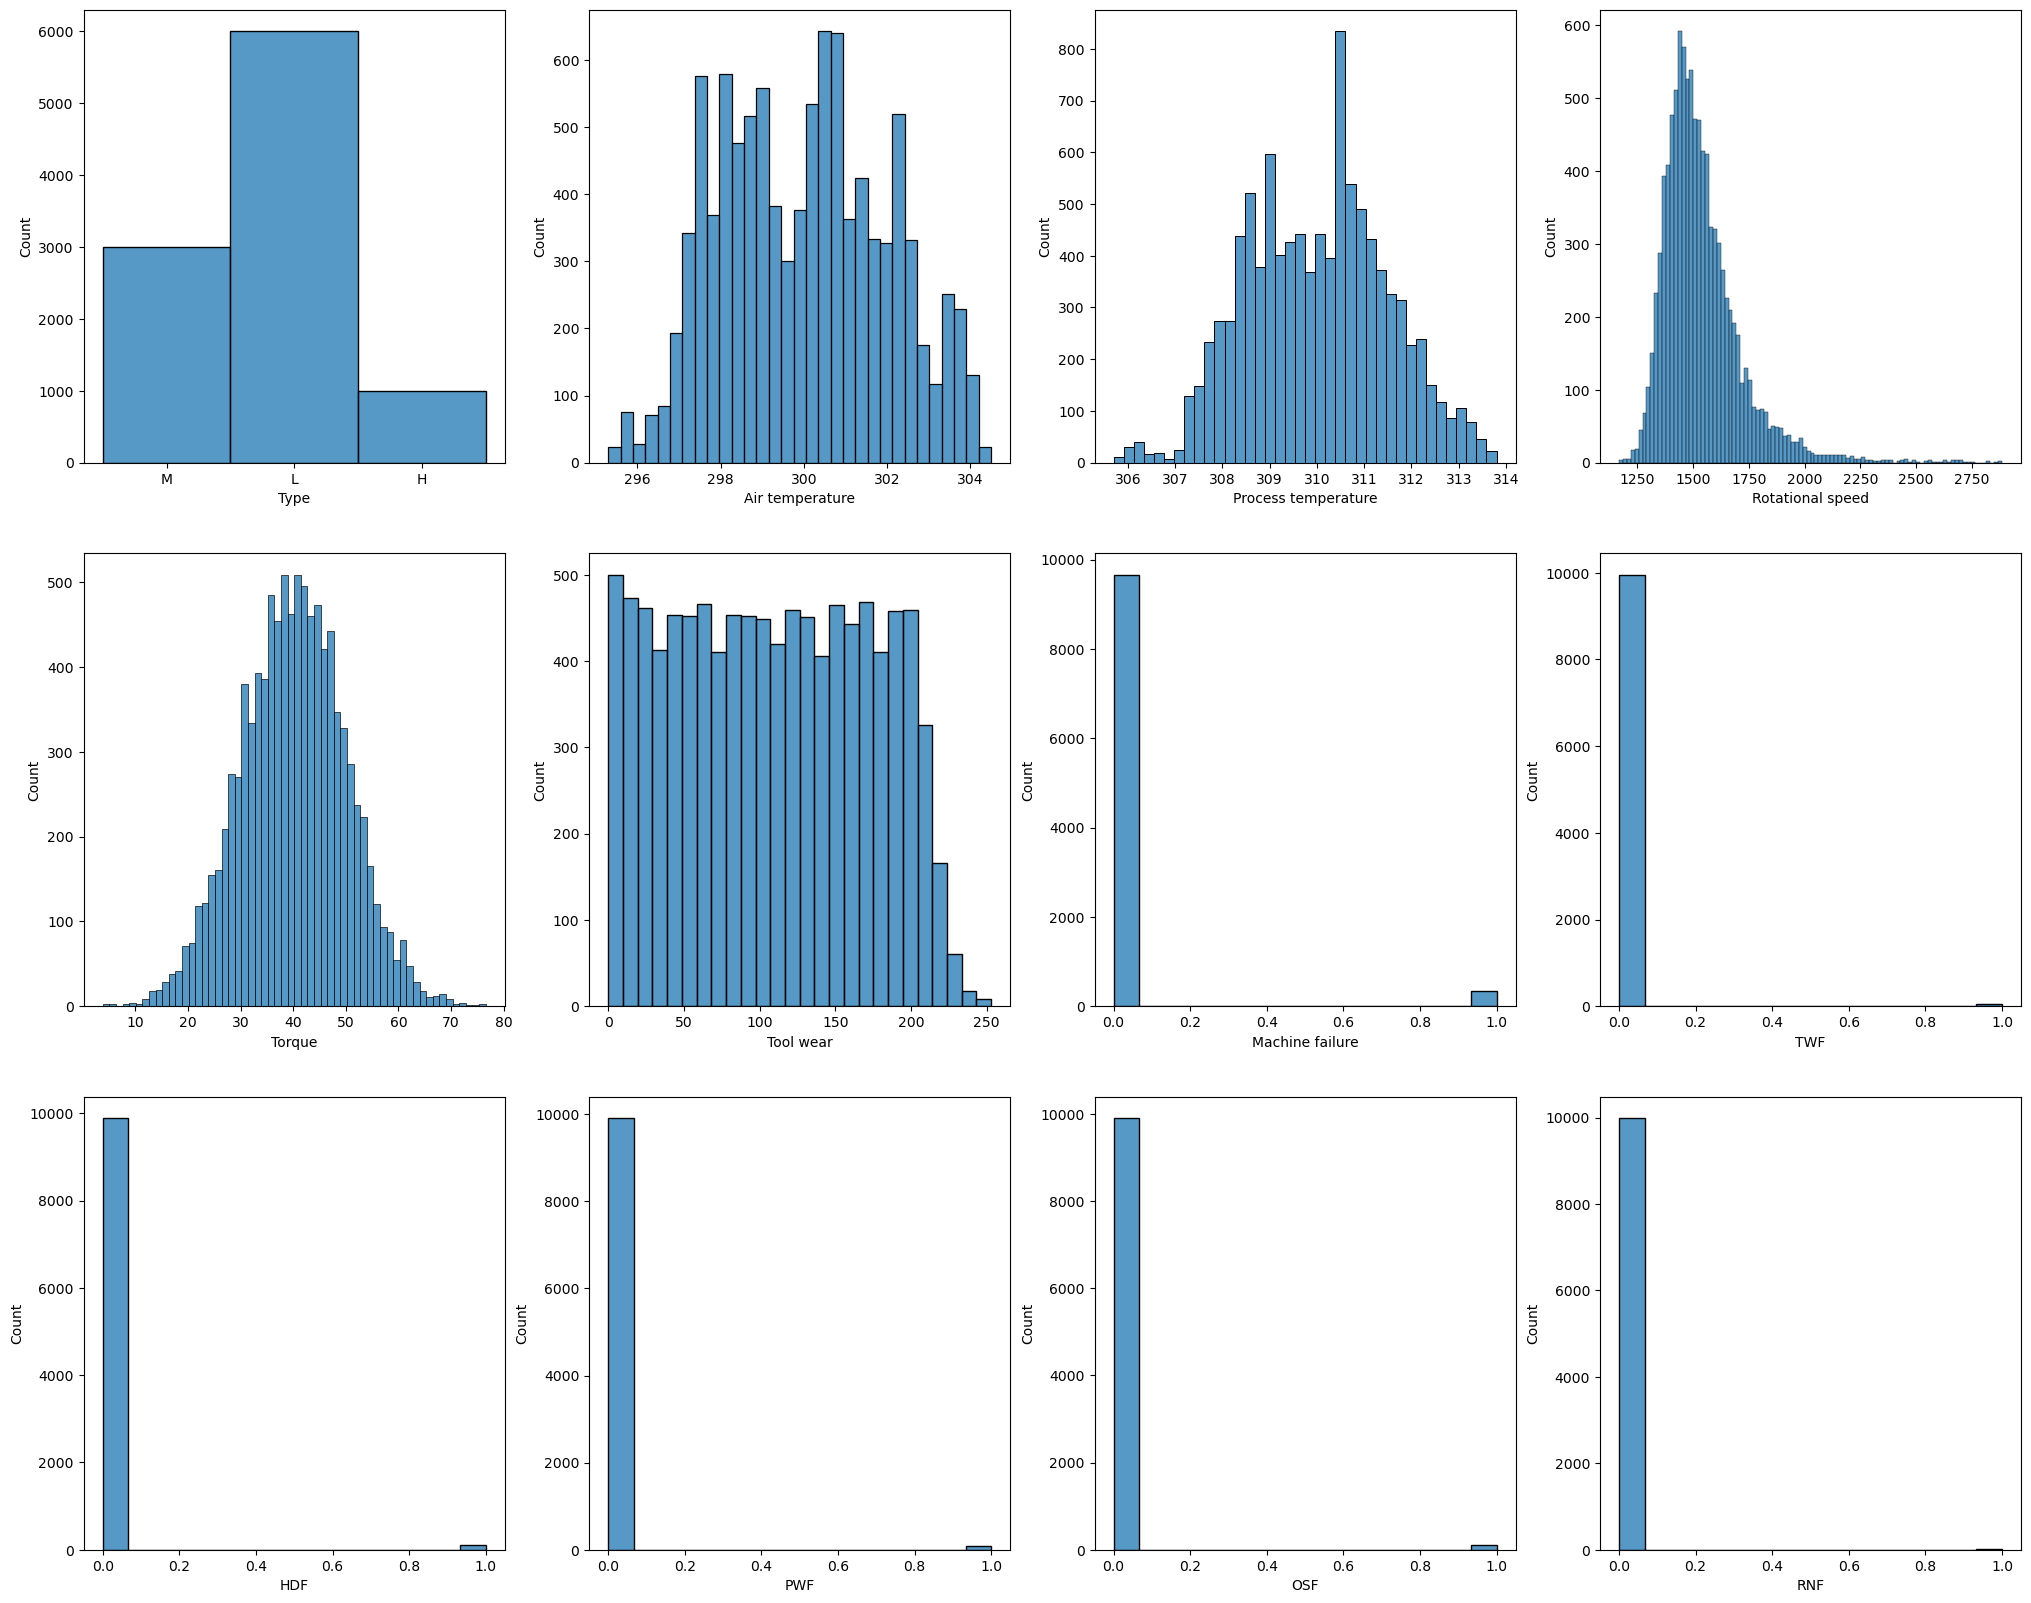

In [11]:
fig, ax = plt.subplots(3, 4, figsize=(25, 20))

for i, col in enumerate(data.columns):
    sns.histplot(data[col], ax=ax[i//4][i%4])

Text(0.5, 1.0, 'Number of failure types per record')

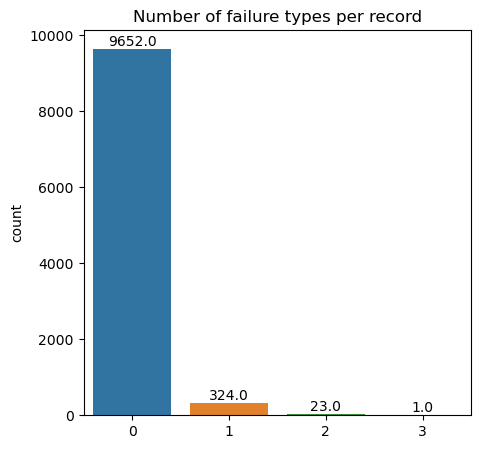

In [12]:
failures = data.loc[:, ['TWF','HDF', 'PWF', 'OSF', 'RNF']] 

# Calculating sum of values for each row (Failure)

rows_sum = failures.sum(axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=rows_sum, ax=ax)
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
ax.set_title('Number of failure types per record')

24 records contain more than one type of failure, since their count is very small compared to the entire data set we will combine the failure types into single feature. Then we can drop the individual failure types.

> No failure = 0, TWF = HDF = PWF = OSF = RNF = 1


In [13]:
data['Machine failure'] = 0

data.loc[data['TWF'] == 1, 'Machine failure'] = 1
data.loc[data['HDF'] == 1, 'Machine failure'] = 1
data.loc[data['PWF'] == 1, 'Machine failure'] = 1
data.loc[data['OSF'] == 1, 'Machine failure'] = 1
data.loc[data['RNF'] == 1, 'Machine failure'] = 1

# drop individual failure types
data.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

Text(0.5, 1.0, 'Count of different failure types')

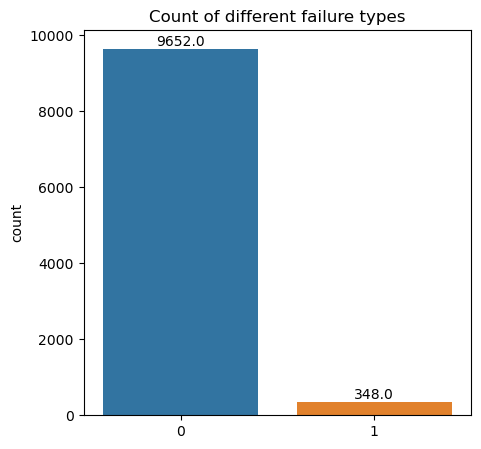

In [14]:
failures = data.loc[:, ['Machine failure']] 

# Calculating sum of values for each row (Failure)

rows_sum = failures.sum(axis=1)

fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=rows_sum, ax=ax)
for patch in ax.patches:
    ax.annotate(str(patch.get_height()), (patch.get_x() + patch.get_width()/2, patch.get_height()), ha='center', va='bottom')
ax.set_title('Count of different failure types')

$Power = Torque \times Rotational \ speed$

Power can be used as a new attribute 

In [15]:
data['Power'] = data['Rotational speed']*data['Torque']

<Axes: xlabel='Power', ylabel='Count'>

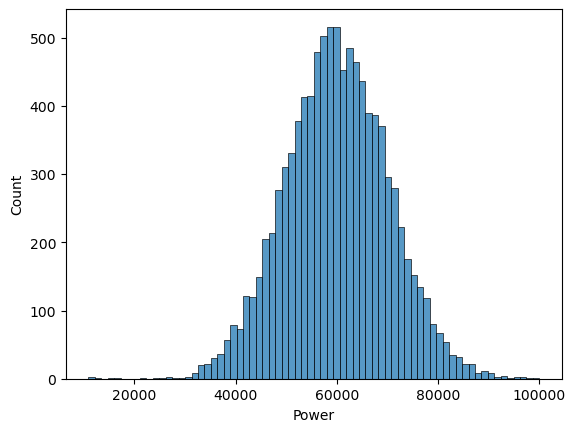

In [16]:
# Plot the histogram of Power attribute
sns.histplot(data['Power'])

In [17]:
# convert Type attribute into numbers, such that L = 0, M = 1, and H = 2
data['Type'].replace('L', 0, inplace=True)
data['Type'].replace('M', 1, inplace=True)
data['Type'].replace('H', 2, inplace=True)

In [18]:
# covert all the columns into float data type for easier processing
for column in data.columns:
    data[column] = data[column].astype(float)
    
print(data.dtypes)

Type                   float64
Air temperature        float64
Process temperature    float64
Rotational speed       float64
Torque                 float64
Tool wear              float64
Machine failure        float64
Power                  float64
dtype: object


## **Handling outliers**❗

Calculate and handle the outliers for each attribute using IQR and Winsorization

In [19]:
# List the columns to exclude from normalization and winsorization
excluded_columns = ['Type', 'Machine failure']

for col in data.columns:
    if col not in excluded_columns:
        # calculate the IQR (interquartile range)
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data[col] <= (Q1 - 1.5 * IQR)) | (data[col] >= (Q3 + 1.5 * IQR))]
        if not outliers.empty:
          #data.loc[outliers.index, col] = winsorize(outliers[col], limits=[0.08, 0.08])
          data.drop(outliers.index, inplace=True)

Density-Based Anomaly Detection(LOF)

In [20]:
from sklearn.neighbors import LocalOutlierFactor

# create the LOF model
model = LocalOutlierFactor(n_neighbors=5)

# use the model to predict the outlier scores for each row
scores = model.fit_predict(data)

# identify the outlier rows (those with a negative score) and remove them
outliers = data[scores == -1]
if not outliers.empty:
    data.drop(outliers.index, inplace=True)

In [21]:
# shape of the Dataset after removing the outliers
data.shape

(9400, 8)

## **Transformation** ⛏️

Normalize the attributes using z-score

$z = \frac{x - \mu} {\sigma}$, $\mu:$ Mean, $σ:$ Standard deviation

In [22]:
from scipy.stats import zscore

# Iterate over the columns in the dataframe
for col in data.columns:
      if col not in excluded_columns:
        # Normalize the values in the column
        data[col] = zscore(data[col])

## **More visualizations** 📊 

Box and Whisker Plots for each attribute compared with Machine failure

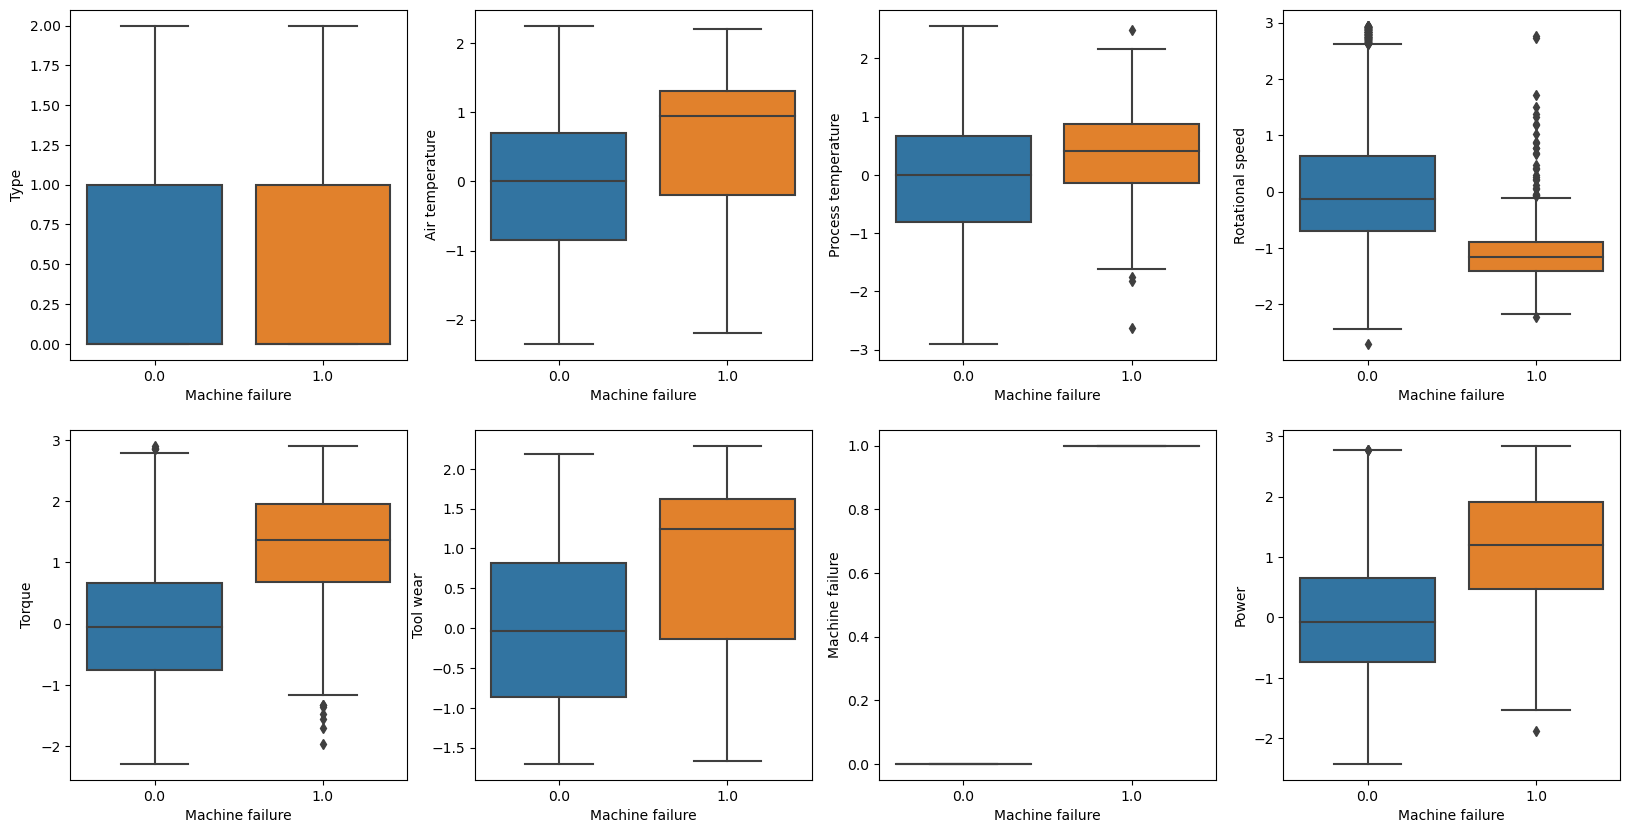

In [23]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

for i, col in enumerate(data.columns):
    sns.boxplot(x='Machine failure', y=col, data=data, ax=ax[i//4][i%4])

Box and Whisker Plots for each attribute

<Axes: title={'center': 'Box and Whisker Plots'}>

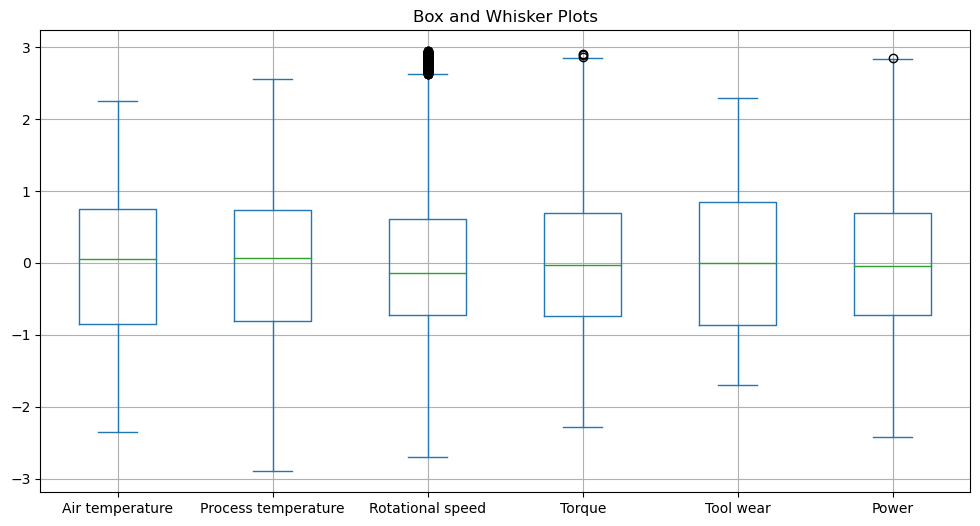

In [24]:
plot_columns = [col for col in data.columns if col not in excluded_columns]
data[plot_columns].plot(kind='box', figsize=(12,6),
                       title='Box and Whisker Plots', grid=True)

<Axes: >

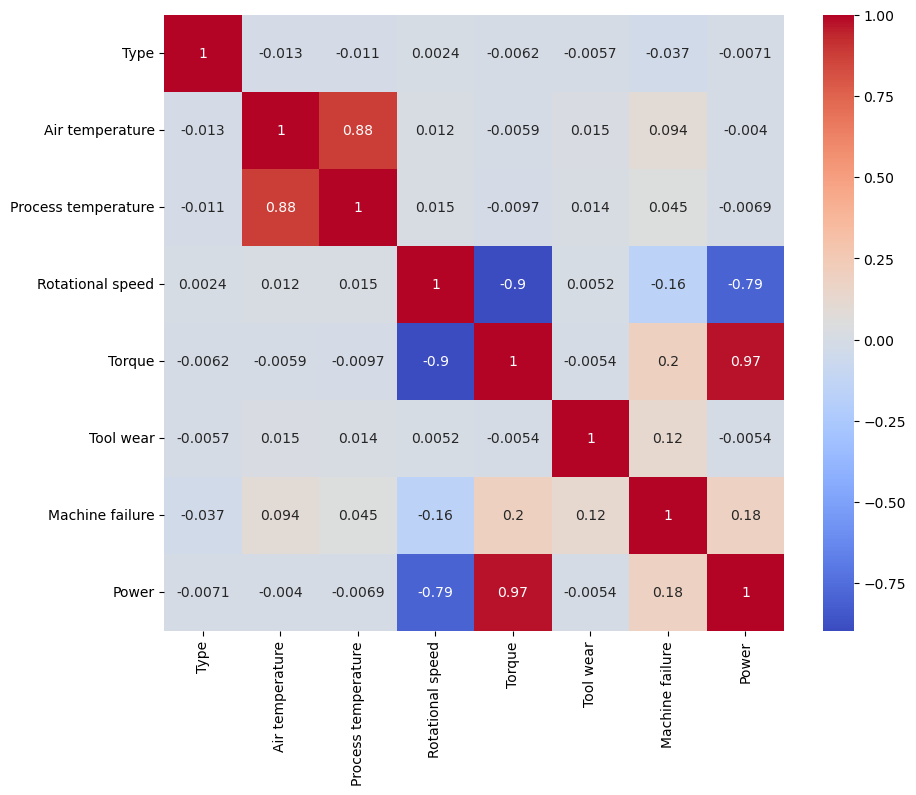

In [25]:
# Finding the correlation between the attributes
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)

C:\Users\Kaavi\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


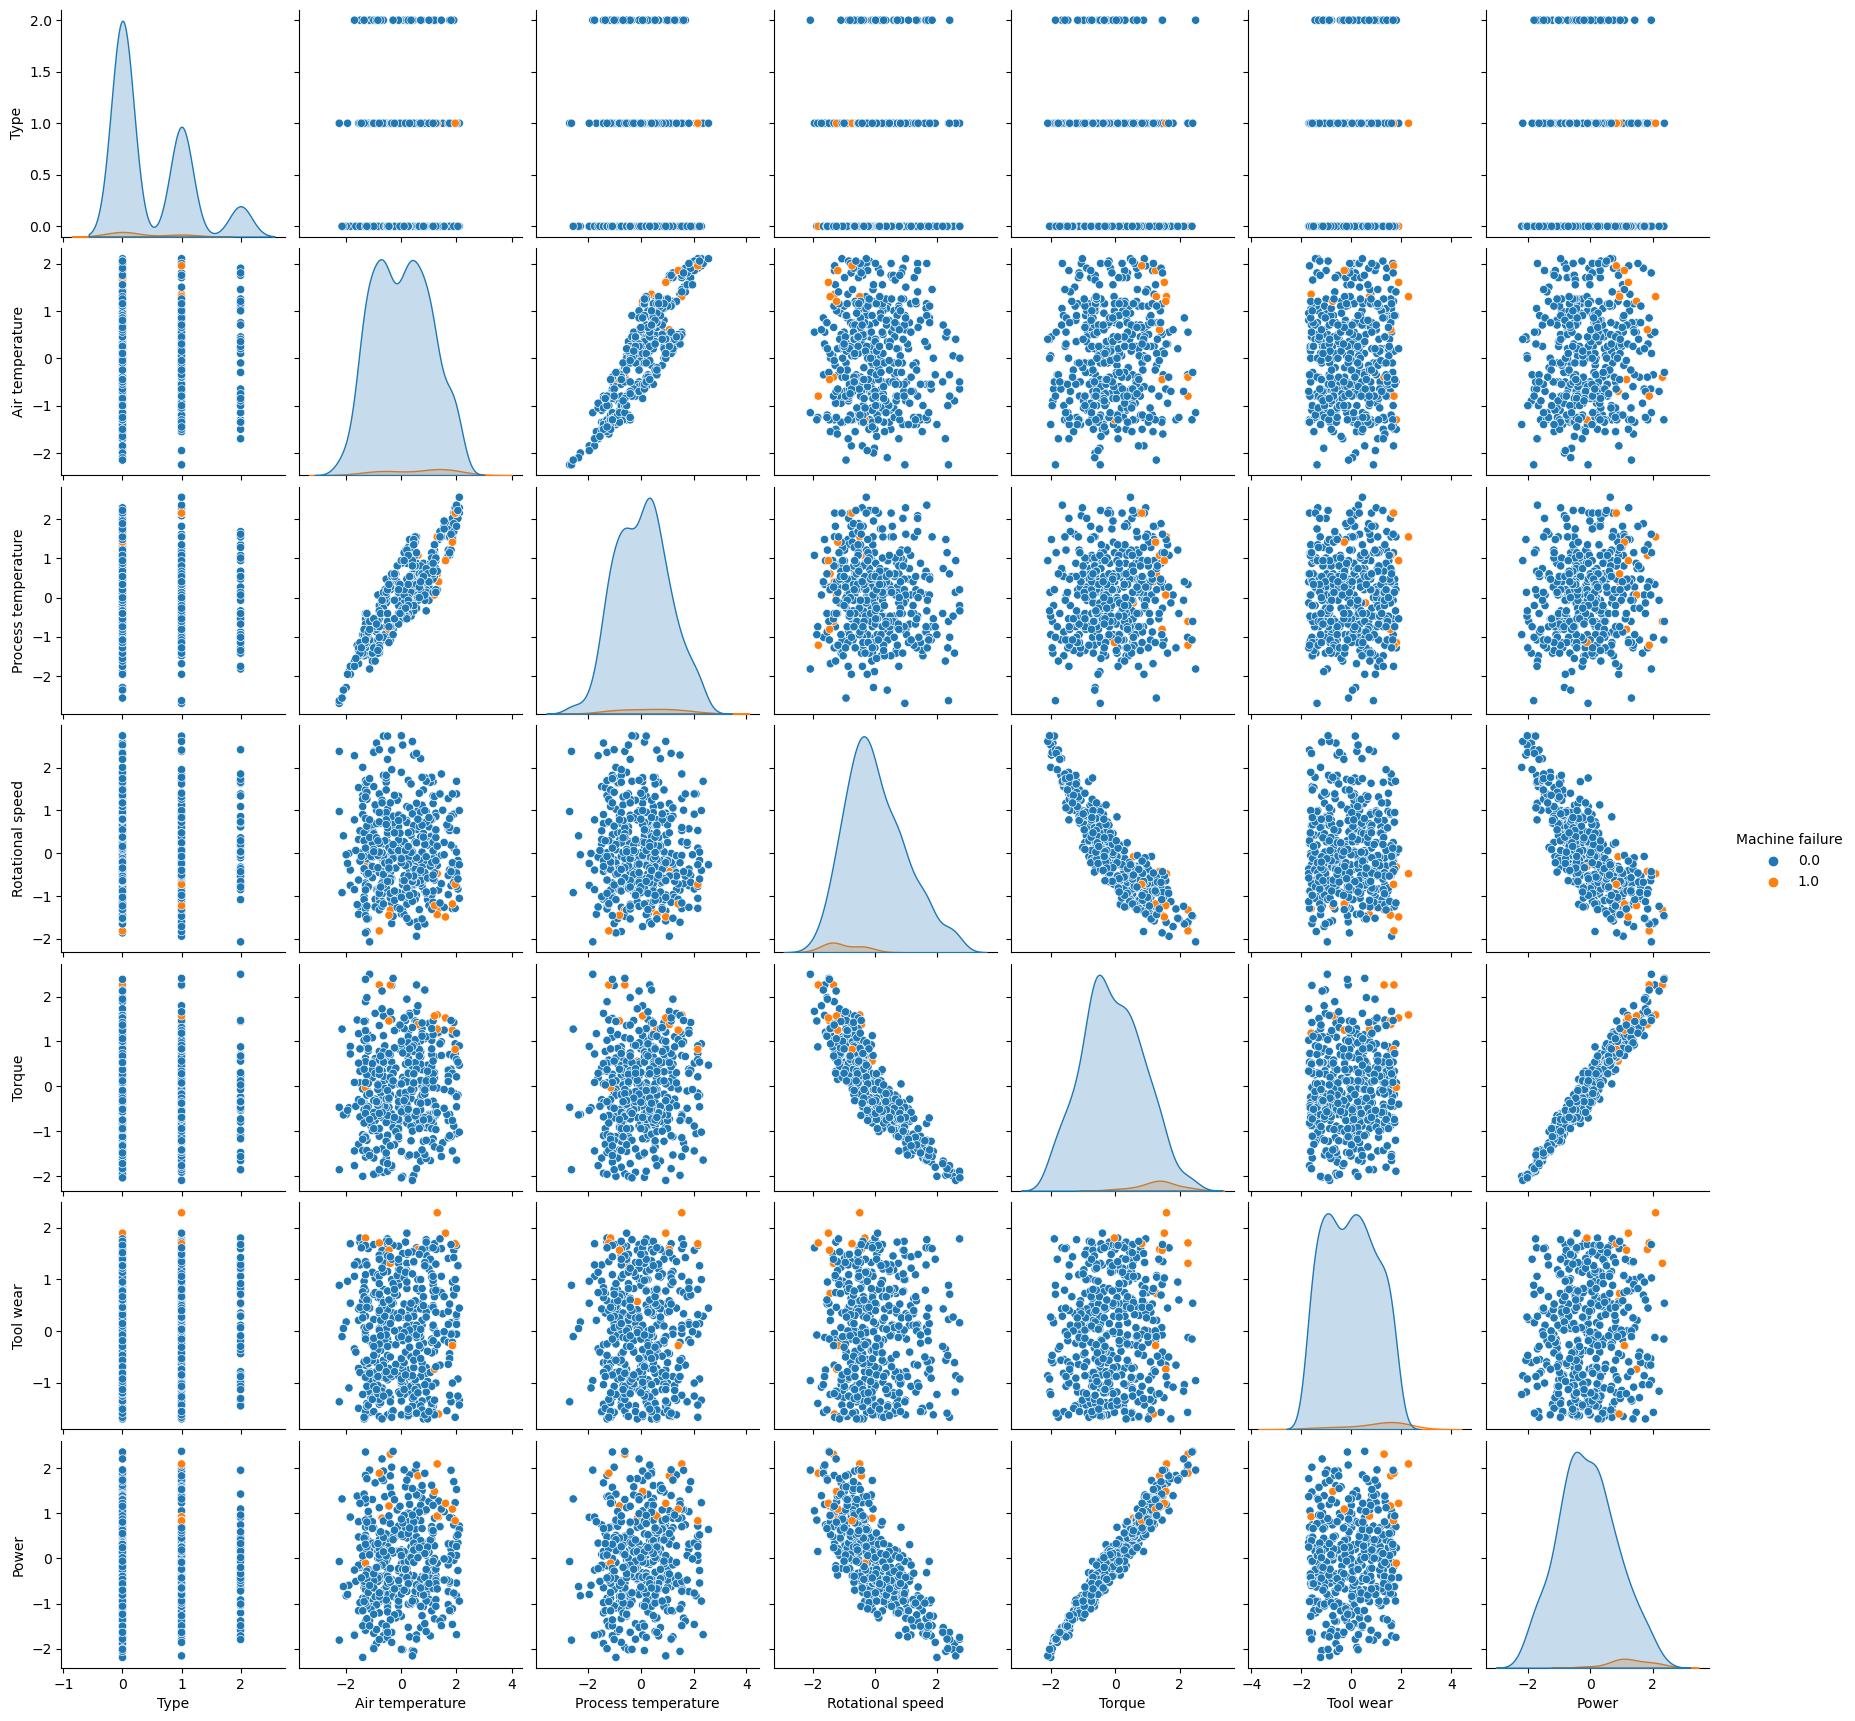

In [26]:
# scatterplot matrix to visualize the correlation between attributes
sns.pairplot(data.sample(frac=0.05), hue='Machine failure')

<Axes: >

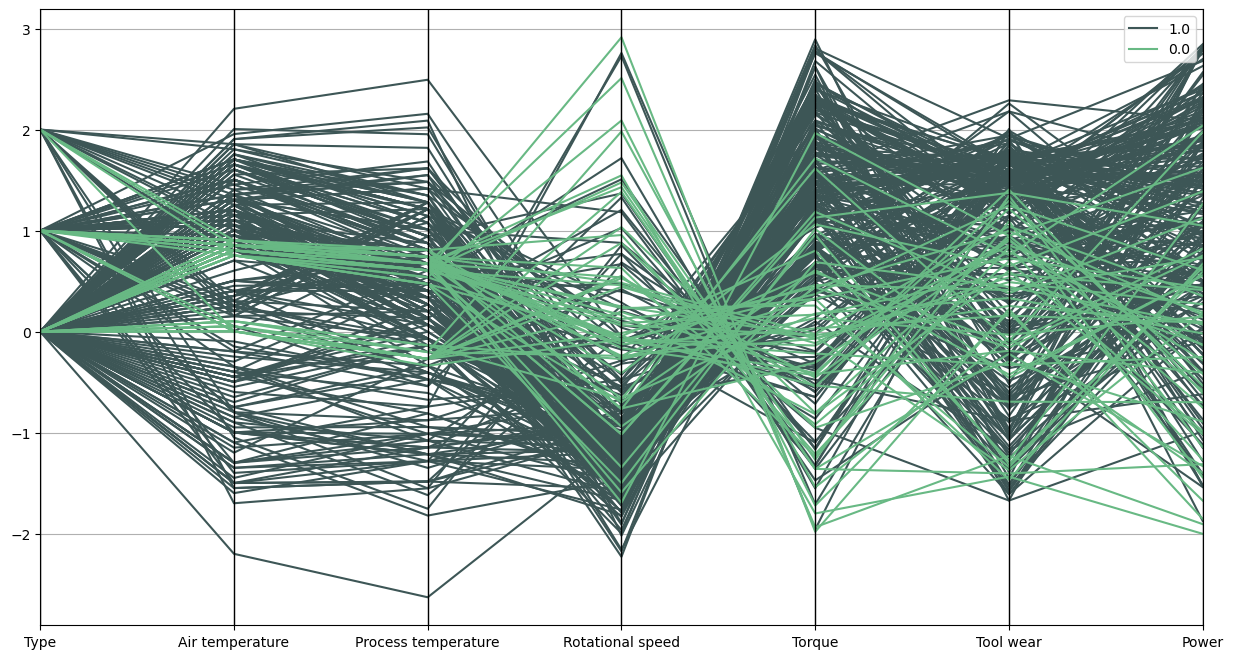

In [27]:
# parallet co-ordinate plot 
sample = data.sort_values(by=['Machine failure'], ascending=False).head(300)

plt.figure(figsize=(15,8))
pd.plotting.parallel_coordinates(sample, "Machine failure", color=('#3D5656', '#68B984', '#FED049'))

Generate a profile report that includes (outliers, missing values, distributions, etc.) using [pandas-profiling](https://pandas-profiling.ydata.ai/docs/master/index.html)

In [28]:
data_profile = pdpf.ProfileReport(data, dark_mode=True)
data_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Descriptive analytics** 📝



## **Clustering** 🧩


In [29]:
# features to use for clustering
X = data[["Air temperature", "Process temperature", "Rotational speed", "Torque", "Tool wear", "Power"]]

* Paritional Clustering, **K-means algorithm**

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

data['kmeans_cluster'] = kmeans.predict(X)

# plot the results

C:\Users\Kaavi\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

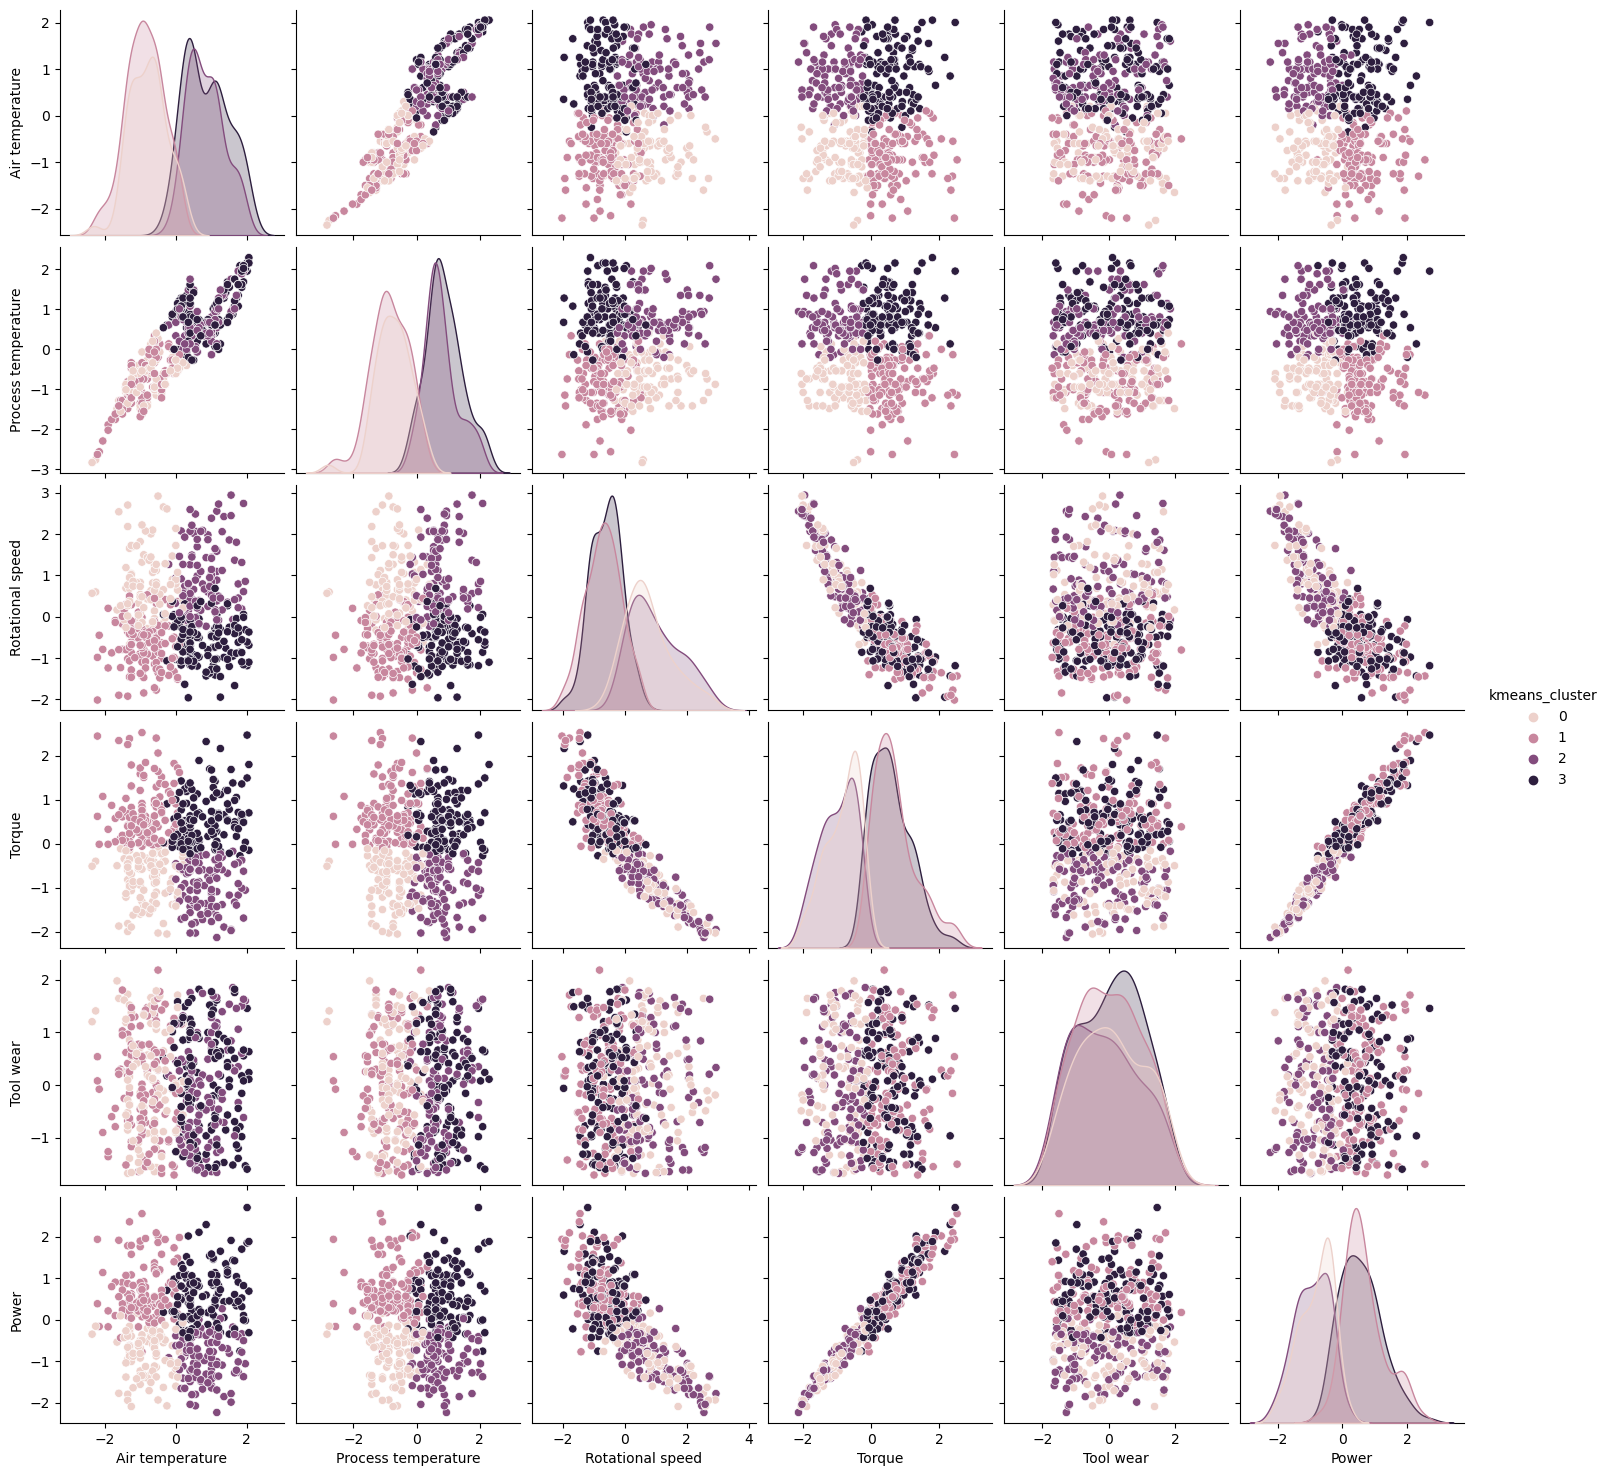

In [31]:
plt.figure(figsize=(10,8))

# create a pairplot of the data, colored by cluster label
sns.pairplot(data.sample(frac=0.05), hue ='kmeans_cluster', vars=["Air temperature", "Process temperature", "Rotational speed", "Torque", "Tool wear", "Power"])

Silhouette coefficient for k-means algorithm

In [32]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, kmeans.predict(X))

print(f"Silhouette Coefficient: {score: .3f}")

Silhouette Coefficient:  0.225


* Density-based clustering, **DBSACN**

Determining EPS and MinPts for DBSACN algorithm

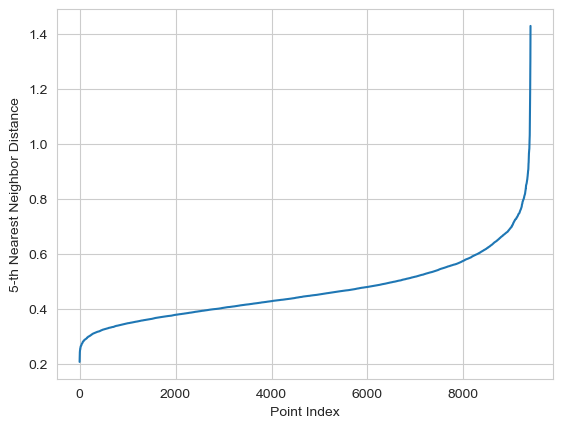

In [33]:
from sklearn.neighbors import NearestNeighbors

k =5 

# create the nearest neighbors model
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)

# get the distances and indices of the kth nearest neighbors for each point
distances, indices = nn.kneighbors(X)

# get the kth nearest neighbor distances for each point
kth_distances = distances[:, k-1]

# sort the kth nearest neighbor distances
kth_distances_sorted = np.sort(kth_distances)

sns.set_style('whitegrid')
plt.plot(kth_distances_sorted)
plt.xlabel('Point Index')
plt.ylabel('5-th Nearest Neighbor Distance')
plt.show()


In [34]:
from sklearn.cluster import DBSCAN

# create a DBSCAN model 
model = DBSCAN(eps=0.7, min_samples=5)
model.fit(X)

# obtain the cluster labels
data['dbscan_cluster'] = model.labels_

In [35]:
from sklearn.metrics import silhouette_score

#calculate teh silhouette coefficient
score = silhouette_score(X, data['dbscan_cluster'])

print(f"Silhouette Coefficient: {score:.3f}")

Silhouette Coefficient: 0.292


plot the results

C:\Users\Kaavi\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

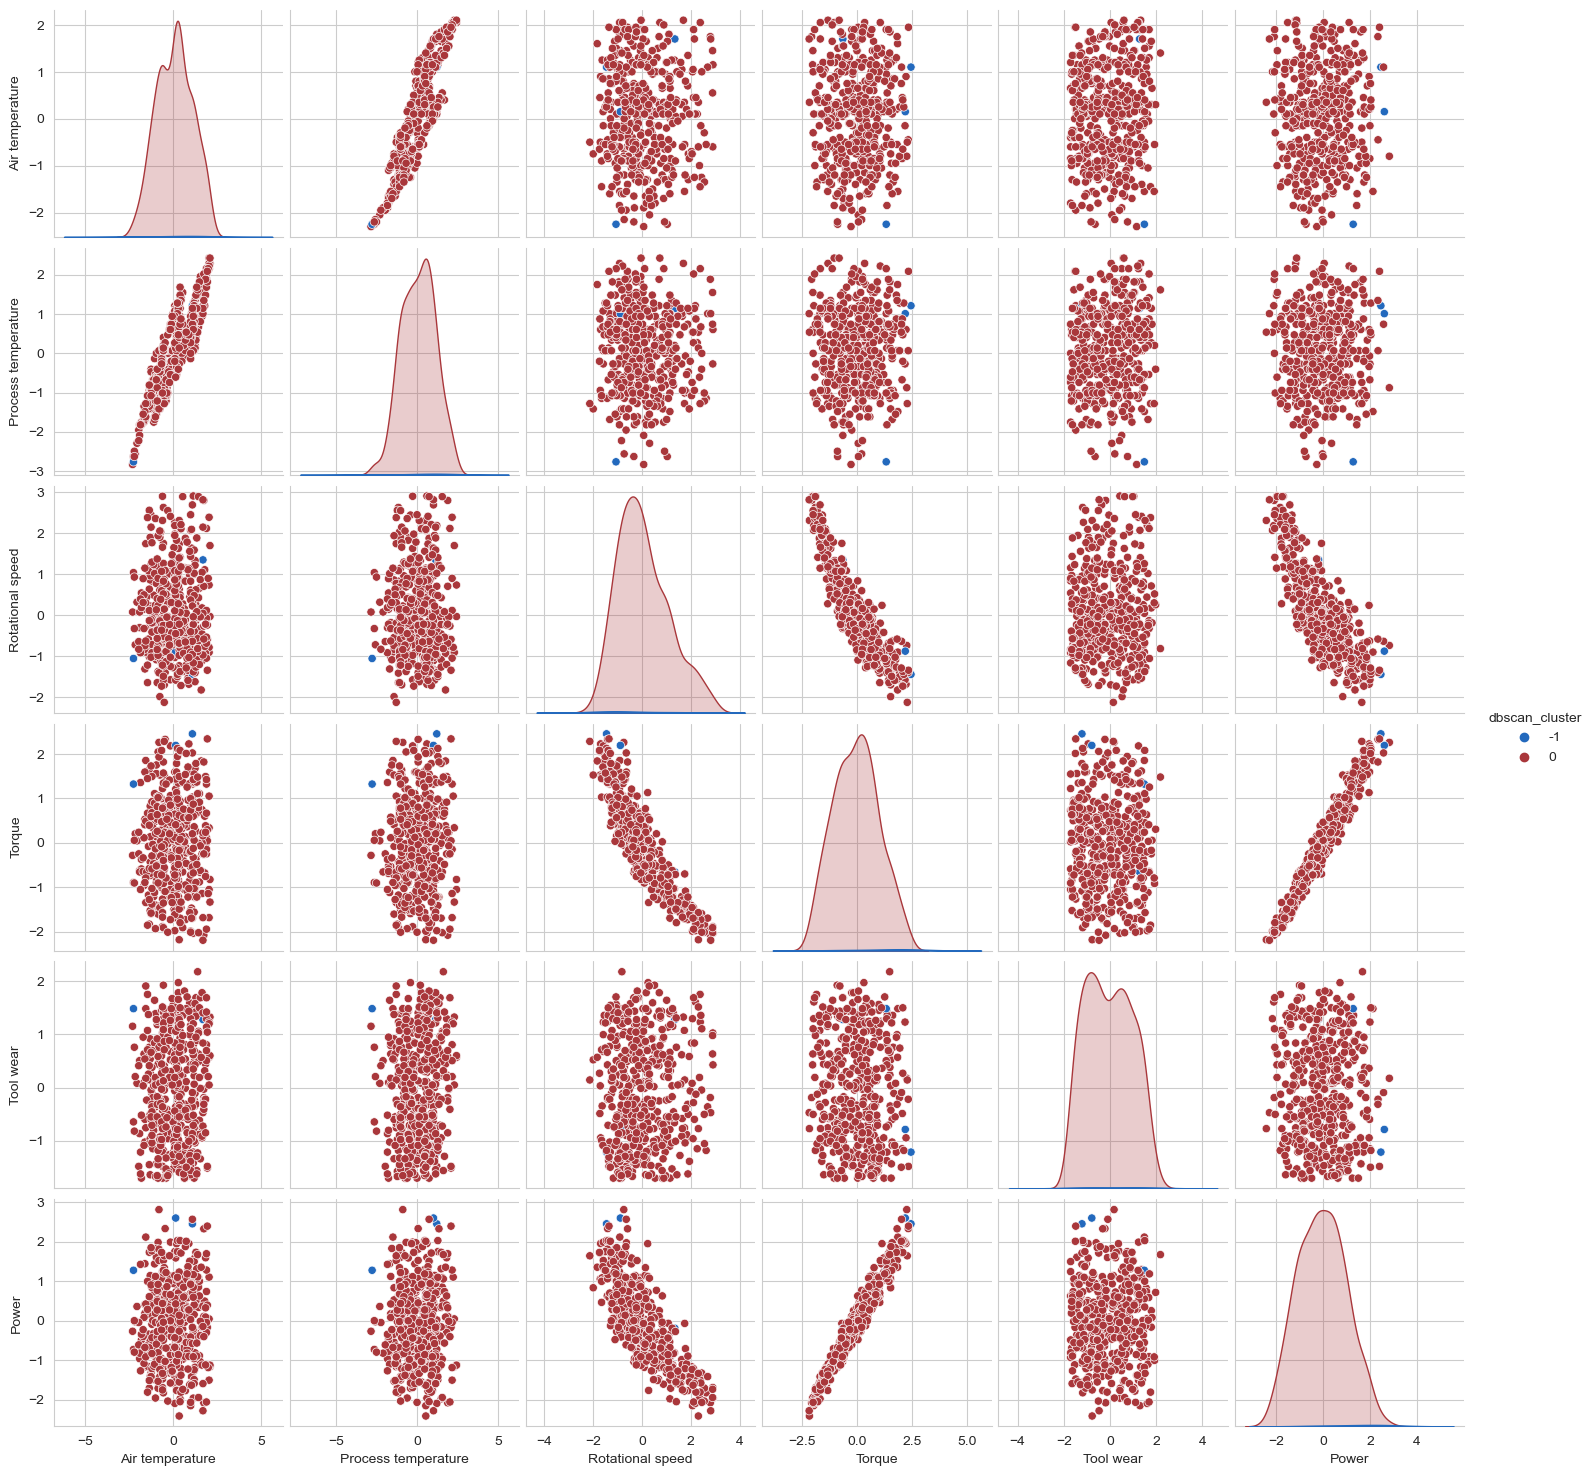

In [36]:
plt.figure(figsize=(10, 8))

# create a pairplot of the data, colored by cluster label
sns.pairplot(data.sample(frac=0.05), hue="dbscan_cluster", palette="vlag", vars=["Air temperature", "Process temperature", "Rotational speed", "Torque", "Tool wear", "Power"])

# **Modeling** 🧪

In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import time

model_performance = pd.DataFrame(columns=['Accuracy', 'Precision',
                                          'Recall', 'F1-Score', 'Training time',
                                          'Prediction time'])

def log_scores(model_name, y_test, y_predictions):
    accuracy = accuracy_score(y_test, y_predictions)
    precision = precision_score(y_test, y_predictions, average='weighted')
    recall = recall_score(y_test, y_predictions, average='weighted')
    precision = precision_score(y_test, y_predictions, average='weighted')
    f1 = f1_score(y_test, y_predictions, average='weighted')

    # save the scores in model_performance dataframe
    model_performance.loc[model_name] = [accuracy, precision, recall, f1,
                                       end_train-start, end_predict-end_train]

## **Data splitting and sampling** 🧮

In [38]:
print(data.columns)

Index(['Type', 'Air temperature', 'Process temperature', 'Rotational speed',
       'Torque', 'Tool wear', 'Machine failure', 'Power', 'kmeans_cluster',
       'dbscan_cluster'],
      dtype='object')


Split the dataset(70% train : 30% test)

In [39]:
from sklearn.model_selection import train_test_split

X = data.drop(['Machine failure','kmeans_cluster', 'dbscan_cluster'], axis=1)
y = data['Machine failure']

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, 
                                                    random_state = 0,
                                                    stratify = y)

Because the data is imbalanced, we oversample the training set

In [40]:
import imblearn

In [41]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler

oversample = SVMSMOTE(random_state = 42)
#oversample = RandomOverSampler(random_state=42)

X_train, y_train = oversample.fit_resample(X_train, y_train)

## **Decision Tree Model**

In [42]:
from sklearn.tree import DecisionTreeClassifier

start = time.time()
model = DecisionTreeClassifier(max_depth = 8).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Decision Tree", y_test, y_predictions)

In [43]:
print("Decision Tree\n" + classification_report(y_test, y_predictions))

Decision Tree
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2746
         1.0       0.40      0.72      0.51        74

    accuracy                           0.96      2820
   macro avg       0.70      0.84      0.75      2820
weighted avg       0.98      0.96      0.97      2820



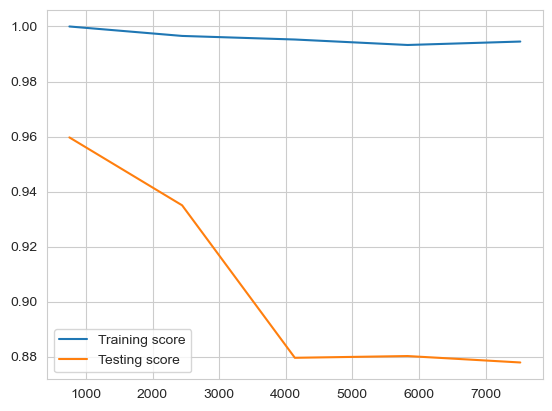

In [44]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

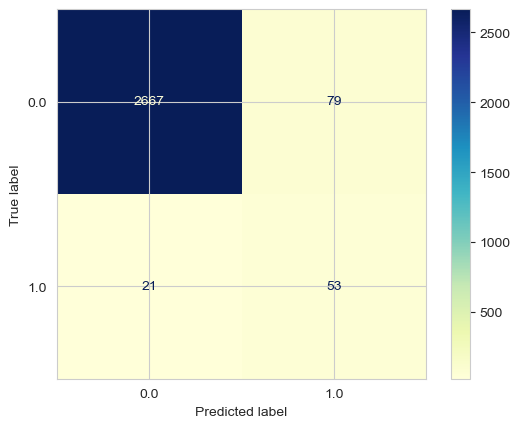

In [45]:
# confusion matrix for decison tree model
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap='YlGnBu')

In [47]:
import graphviz


## **k-NN (K-nearest neighbors) Model**

In [57]:
import warnings

# Filter out the FutureWarning related to the mode function
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors._classification")

In [58]:
from sklearn.neighbors import KNeighborsClassifier

# creating the model
knn = KNeighborsClassifier(n_neighbors=1)

# fit the data to the model
knn.fit(X_train,y_train)

# predictions from the test set
pred_1 = knn.predict(X_test)

# evaluate the model
print(classification_report(y_test,pred_1))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      2746
         1.0       0.44      0.50      0.47        74

    accuracy                           0.97      2820
   macro avg       0.71      0.74      0.73      2820
weighted avg       0.97      0.97      0.97      2820



In [59]:
error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

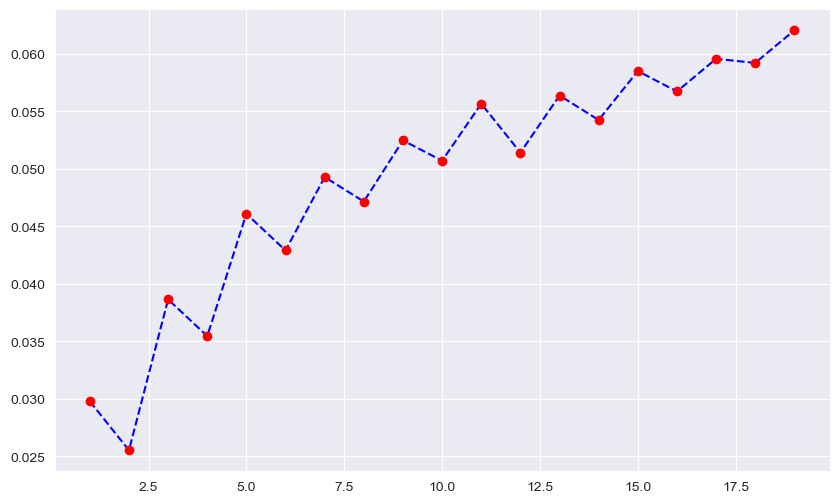

In [60]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))

plt.plot(range(1,20),error_rate,color='blue', ls='--', marker='o',markerfacecolor='red',markeredgecolor='red')

Retrain the model with **K = 2**

In [61]:
# build the model

start = time.time()
model = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # predictions from the testset
end_predict = time.time()

# evaluate the model
log_scores("k-NN", y_test, y_predictions)

In [62]:
print("k-NN Model\n" + classification_report(y_test, y_predictions))

k-NN Model
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2746
         1.0       0.51      0.49      0.50        74

    accuracy                           0.97      2820
   macro avg       0.75      0.74      0.74      2820
weighted avg       0.97      0.97      0.97      2820



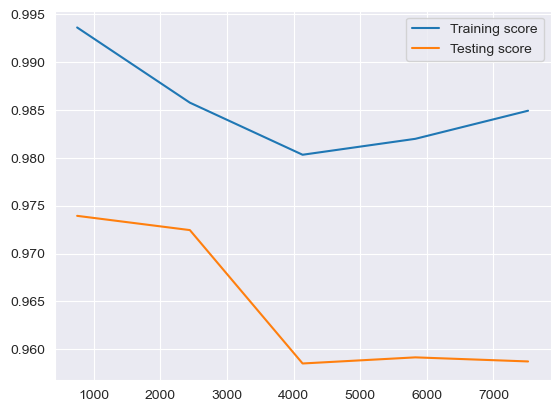

In [63]:
from sklearn.model_selection import learning_curve

train_sizez, train_scores, test_scores = learning_curve(model, X, y, cv=5)

#plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

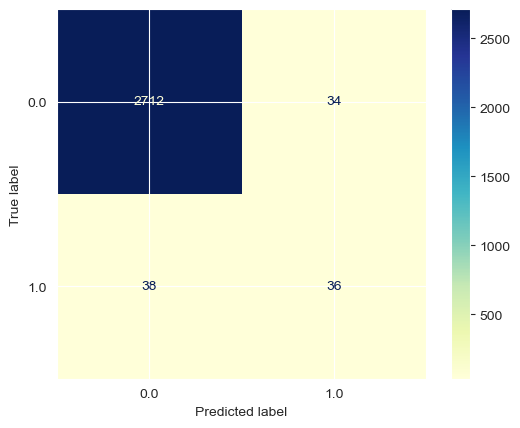

In [65]:
# confusion matrix of K-NN model

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap= plt.cm.YlGnBu)

## **Random Forest Model**

In [66]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
model = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                               random_state=0, bootstrap=True).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Random Forest", y_test, y_predictions)

In [67]:
print("Random Forest Model\n" + classification_report(y_test, y_predictions))

Random Forest Model
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2746
         1.0       0.61      0.62      0.61        74

    accuracy                           0.98      2820
   macro avg       0.80      0.81      0.80      2820
weighted avg       0.98      0.98      0.98      2820



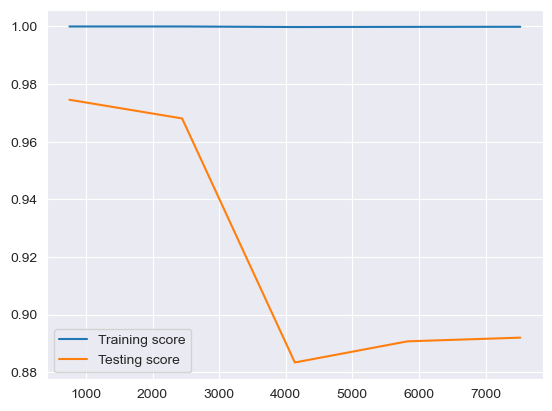

In [68]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

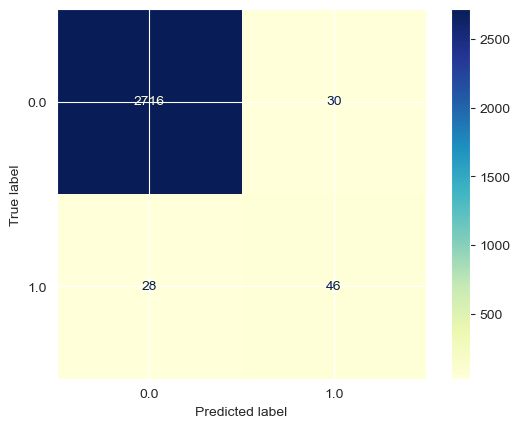

In [70]:
# confusion matrix for Random Forest model

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)

## **Gradient Boosting Model**

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

start = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Gradient Boosting", y_test, y_predictions)

In [72]:
print("Gradient Boosting\n" + classification_report(y_test, y_predictions))

Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2746
         1.0       0.42      0.74      0.54        74

    accuracy                           0.97      2820
   macro avg       0.71      0.86      0.76      2820
weighted avg       0.98      0.97      0.97      2820



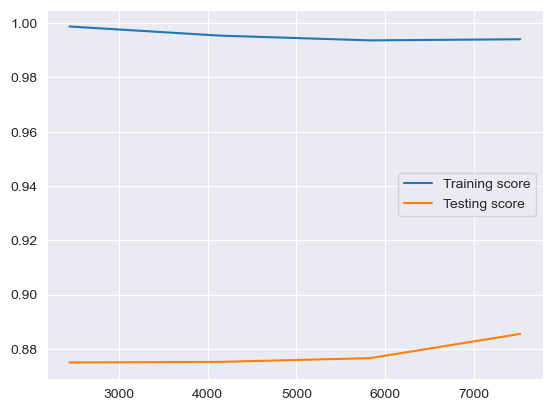

In [73]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

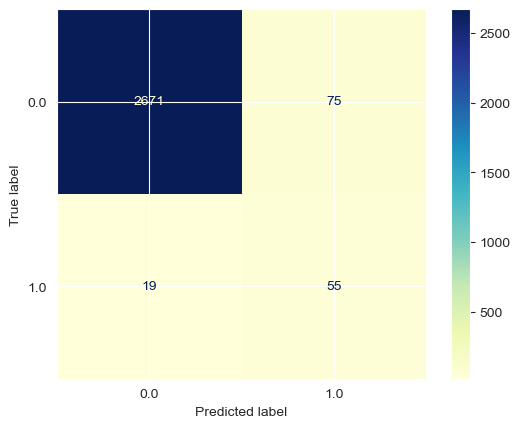

In [74]:
# confusion matrix of Gradient Boosting model

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)

## **Gaussian Naive Bayes Model**

In [75]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
model = GaussianNB().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Gaussian Naive Bayes", y_test, y_predictions)

In [76]:
print("Gaussian Naive Bayes\n" + classification_report(y_test, y_predictions))

Gaussian Naive Bayes
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      2746
         1.0       0.12      0.82      0.20        74

    accuracy                           0.83      2820
   macro avg       0.55      0.83      0.55      2820
weighted avg       0.97      0.83      0.89      2820



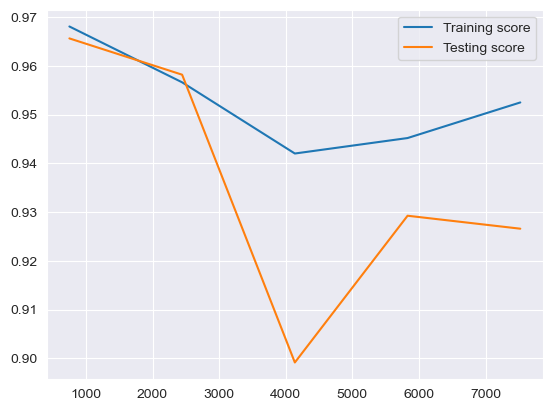

In [77]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

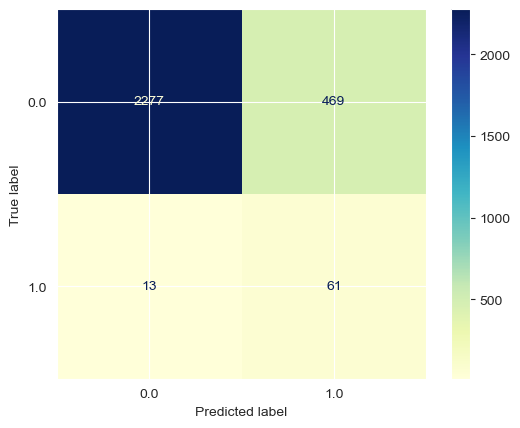

In [78]:
# Confusion matrix of Gaussian Naive Bayes model

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)

## **MLP (Multi-layer Perceptron) Model**


In [79]:
from sklearn.neural_network import MLPClassifier

start = time.time()
model = MLPClassifier(random_state=1, max_iter=600, learning_rate="invscaling").fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Multi-layer Perceptron", y_test, y_predictions)

In [80]:
print("Multi-layer Perceptron\n" + classification_report(y_test, y_predictions))

Multi-layer Perceptron
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      2746
         1.0       0.51      0.74      0.61        74

    accuracy                           0.97      2820
   macro avg       0.75      0.86      0.80      2820
weighted avg       0.98      0.97      0.98      2820



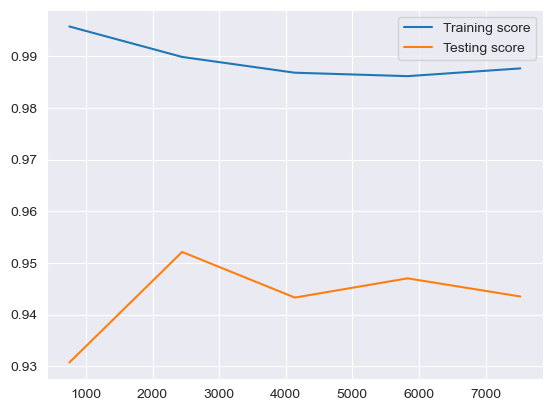

In [81]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

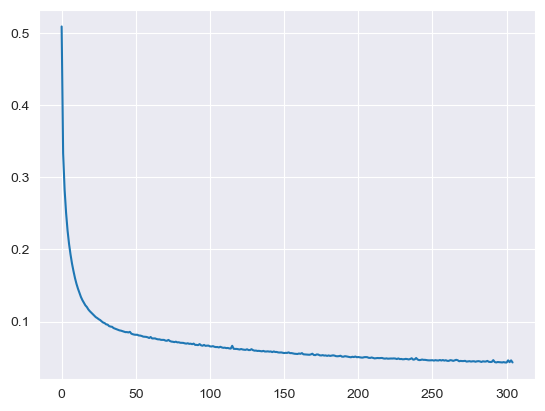

In [82]:
plt.plot(model.loss_curve_)

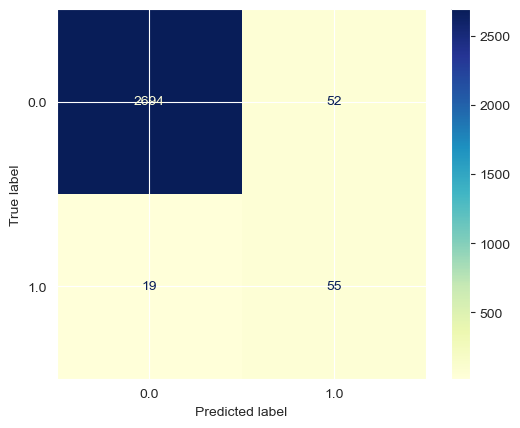

In [83]:
# confusion matrix for Multi-Layer Perceptron model

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)

# **Evaluation** 🎲

In [84]:
model_performance

Accuracy  Precision    Recall  F1-Score  \
Decision Tree           0.964539   0.976688  0.964539  0.969342   
k-NN                    0.974468   0.973799  0.974468  0.974123   
Random Forest           0.979433   0.979705  0.979433  0.979566   
Gradient Boosting       0.966667   0.977983  0.966667  0.971070   
Gaussian Naive Bayes    0.829078   0.971251  0.829078  0.885860   
Multi-layer Perceptron  0.974823   0.980428  0.974823  0.977042   

                        Training time  Prediction time  
Decision Tree                0.053687         0.002002  
k-NN                         0.015119         0.122779  
Random Forest                0.350775         0.038999  
Gradient Boosting            2.287286         0.008000  
Gaussian Naive Bayes         0.005007         0.002000  
Multi-layer Perceptron      13.742719         0.010004

In [85]:
import pickle

# build the Decision Tree classifier
model = DecisionTreeClassifier(max_depth = 8).fit(X_train, y_train)

# save the model
pickle.dump(model, open('finalized_model.pkl', 'wb'))

# **Deployment** 📤

In [86]:
!pip install gradio --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-lsp-black 1.2.1 requires black>=22.3.0, but you have black 0.0 which is incompatible.
ydata-profiling 4.6.0 requires pydantic<2,>=1.8.1, but you have pydantic 2.5.1 which is incompatible.


Load the saved model and the dataframe

In [90]:
loaded_model = pickle.load(open("finalized_model.pkl", 'rb'))

In [92]:
dataset = pd.read_csv('ai4i2020_v2.csv')

# rename dataset columns
dataset.rename(columns = {'Air temperature [K]':'Air temperature',
                     'Process temperature [K]':'Process temperature',
                     'Rotational speed [rpm]':'Rotational speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool wear'},
          inplace = True)
dataset['Power'] = dataset[['Rotational speed', 'Torque']].product(axis=1)

In [93]:
# normalize the feature using z-score normalization
def z_score(feature, value):
    mean = np.mean(dataset[feature])
    std = np.std(dataset[feature])
    return (float(value) - mean) / std

In [97]:
import gradio as gr
from sklearn.preprocessing import StandardScaler

def predict(air_temperature, process_temperature, rotational_speed, torque, tool_wear, type):
    # normalize the inputs
    air_temperature = z_score('Air temperature', air_temperature)
    process_temperature = z_score('Process temperature', process_temperature)
    rotational_speed = z_score('Rotational speed', rotational_speed)
    torque = z_score('Torque', torque)
    tool_wear = z_score('Tool wear', tool_wear)
    power = z_score('Power', torque * rotational_speed)

    mapping = {'L': 0, 'M': 1, 'H': 2}
    temp = [{'Type':mapping[type], 'Air temperature':air_temperature,
             'Process temperature':process_temperature, 'Rotational speed':rotational_speed,
             'Torque':torque, 'Tool wear':tool_wear, 'Power':power}]

    input_data = pd.DataFrame(temp) 
    prediction = model.predict_proba(input_data)

    classes = ["No failure", "Machine failure"]
    prediction_dict = dict
    for record in prediction:
        prediction_dict = {classes[i] : record[i] for i in range(2)}
    
    maintenance = "No action required"
    if max(prediction_dict, key=prediction_dict.get) != "No failure":
        maintenance = "Need maintenance"

    return prediction_dict, maintenance

# create the user interface (inputs and outputs)
demo = gr.Interface(
    fn=predict,
    inputs=[gr.Slider(100, 350, label="Air temperature"),
            gr.Slider(100, 350, label="Process temperature"),
            gr.Number(label="Rotational speed"),
            gr.Number(label="Torque"),
            gr.Number(label="Tool wear"),
            gr.Radio(["L", "M", "H"], label="Type")],
    outputs=[gr.Label(num_top_classes=2, label="Result"), gr.components.Textbox(label="Action")]
)
demo.launch()

ImportError: cannot import name 'Doc' from 'typing_extensions' (C:\Users\Kaavi\anaconda3\lib\site-packages\typing_extensions.py)